In [12]:
import pandas as pd
import numpy as np
import math
import warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, KFold, ShuffleSplit, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif, chi2, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.exceptions import ConvergenceWarning
from tqdm import tqdm, tqdm_notebook

# Preprocessing

### Import Dataset

In [13]:
df = pd.read_csv(
    "../Datasets/Raw_Data/GSE221521_gene_expression.csv", index_col=1)
df.head()

gene_id  \
gene_name                     
AC073488.4  ENSG00000282222   
AC119427.1  ENSG00000282221   
MIR543      ENSG00000212040   
MADD        ENSG00000110514   
AL356737.2  ENSG00000287159   

                                                  description  \
gene_name                                                       
AC073488.4  chromodomain protein, Y chromosome-like (CDYL)...   
AC119427.1                novel transcript, antisense to LAD1   
MIR543       microRNA 543 [Source:HGNC Symbol;Acc:HGNC:33664]   
MADD        MAP kinase activating death domain [Source:HGN...   
AL356737.2                novel transcript, antisense to GPC5   

                       gene_type                   locus  RNA1_FPKM  \
gene_name                                                             
AC073488.4  processed_pseudogene       X:9410789-9411545   0.000000   
AC119427.1                lncRNA   1:201399633-201401190   0.000000   
MIR543                     miRNA  14:101031987-101032064   0.000000   
MADD              protein_coding    11:47269161-47330031   6.345943   
AL356737.2                lncRNA    13:92610646-92677725   0.000000   

            RNA102_FPKM  RNA104_FPKM  RNA108_FPKM  RNA109_FPKM  RNA110_FPKM  \
gene_name                                                                     
AC073488.4     0.000000     0.000000     0.000000     0.000000     0.000000   
AC119427.1     0.000000     0.000000     0.000000     0.000000     0.000000   
MIR543         0.000000     0.000000     0.000000     0.000000     0.962816   
MADD           8.482109    10.209322     7.143557     5.671481     7.776351   
AL356737.2     0.000000     0.000000     0.000000     0.000000     0.000000   

            ...  R_JS032_count  R_JS033_count  R_JS034_count  R_JS035_count  \
gene_name   ...                                                               
AC073488.4  ...              0              0              0              0   
AC119427.1  ...              0              0              0              0   
MIR543      ...              0              0              0              0   
MADD        ...           1187           1254           1767           1184   
AL356737.2  ...              0              0              0              0   

            R_JS036_count  R_JS037_count  R_JS038_count  R_JS039_count  \
gene_name                                                                
AC073488.4              0              0              1              0   
AC119427.1              0              0              0              0   
MIR543                  0              0              0              0   
MADD                 2418           1294           1254           1461   
AL356737.2              0              0              0              0   

            R_JS040_count  R_JS041_count  
gene_name                                 
AC073488.4              0              0  
AC119427.1              0              0  
MIR543                  0              0  
MADD                 1323           1795  
AL356737.2              0              0  

[5 rows x 390 columns]

### Check Gene Types

In [14]:
df['gene_type'].value_counts()

protein_coding                        19973
lncRNA                                16889
processed_pseudogene                  10162
unprocessed_pseudogene                 2612
misc_RNA                               2220
snRNA                                  1910
miRNA                                  1879
TEC                                    1057
snoRNA                                  943
transcribed_unprocessed_pseudogene      938
transcribed_processed_pseudogene        500
rRNA_pseudogene                         496
IG_V_pseudogene                         187
IG_V_gene                               145
transcribed_unitary_pseudogene          138
TR_V_gene                               106
unitary_pseudogene                       98
TR_J_gene                                79
rRNA                                     53
scaRNA                                   49
polymorphic_pseudogene                   48
IG_D_gene                                37
TR_V_pseudogene                 

### Transform the Dataset

In [15]:
df = df[df['gene_type'] == 'TEC']
df = df.drop(['gene_type', 'description', 'gene_id', 'locus'], axis=1)
df = df.iloc[:, :193]
df = df.T
df.to_csv('../Datasets/Dataset12/data0.csv')

### Combine with Diagnosis

In [16]:
df = pd.read_csv('../Datasets/Dataset12/data0.csv', index_col=0)
diagnosis = pd.read_csv("../Datasets/Dataset05/Diagnosis.csv", index_col=0)
df['Diagnosis'] = diagnosis['Diagnosis']
df.to_csv('../Datasets/Dataset12/data1.csv')

df.head()

AC004801.7  AC092135.3  AC007603.2  AC096656.1  AC097372.2  \
RNA1_FPKM           0.0    2.280802         0.0         0.0    0.170477   
RNA102_FPKM         0.0    1.469661         0.0         0.0    0.970364   
RNA104_FPKM         0.0    1.804569         0.0         0.0    1.588572   
RNA108_FPKM         0.0    1.263218         0.0         0.0    0.172504   
RNA109_FPKM         0.0    1.602708         0.0         0.0    0.343162   

             AC015660.4  AC093831.2  AL117378.2  AC097520.1  AC079456.1  ...  \
RNA1_FPKM      0.000000         0.0         0.0         0.0         0.0  ...   
RNA102_FPKM    0.000000         0.0         0.0         0.0         0.0  ...   
RNA104_FPKM    1.181261         0.0         0.0         0.0         0.0  ...   
RNA108_FPKM    0.000000         0.0         0.0         0.0         0.0  ...   
RNA109_FPKM    0.283535         0.0         0.0         0.0         0.0  ...   

             AC073255.1  AL021408.2  AC099494.1  AC027309.3  AC073578.4  \
RNA1_FPKM           0.0         0.0    0.000000         0.0         0.0   
RNA102_FPKM         0.0         0.0    0.165006         0.0         0.0   
RNA104_FPKM         0.0         0.0    0.216127         0.0         0.0   
RNA108_FPKM         0.0         0.0    0.176085         0.0         0.0   
RNA109_FPKM         0.0         0.0    0.291842         0.0         0.0   

             AL732618.1  AC092437.1  AC131212.4  Z83836.1  Diagnosis  
RNA1_FPKM           0.0    0.303215    0.081479       0.0          1  
RNA102_FPKM         0.0    0.000000    0.000000       0.0          2  
RNA104_FPKM         0.0    0.000000    0.000000       0.0          1  
RNA108_FPKM         0.0    0.000000    0.000000       0.0          1  
RNA109_FPKM         0.0    0.000000    0.000000       0.0          0  

[5 rows x 1058 columns]

### Remove Patients who hasn't Diabetic

In [17]:
df = pd.read_csv('../Datasets/Dataset12/data1.csv', index_col=0)
df = df[df['Diagnosis'] != 0]
df['Diagnosis'] = df['Diagnosis'] - 1
df.to_csv("../Datasets/Dataset12/data2.csv")
df.head()

AC004801.7  AC092135.3  AC007603.2  AC096656.1  AC097372.2  \
RNA1_FPKM           0.0    2.280802         0.0    0.000000    0.170477   
RNA102_FPKM         0.0    1.469661         0.0    0.000000    0.970364   
RNA104_FPKM         0.0    1.804569         0.0    0.000000    1.588572   
RNA108_FPKM         0.0    1.263218         0.0    0.000000    0.172504   
RNA110_FPKM         0.0    2.034561         0.0    0.055058    0.644778   

             AC015660.4  AC093831.2  AL117378.2  AC097520.1  AC079456.1  ...  \
RNA1_FPKM      0.000000         0.0         0.0         0.0         0.0  ...   
RNA102_FPKM    0.000000         0.0         0.0         0.0         0.0  ...   
RNA104_FPKM    1.181261         0.0         0.0         0.0         0.0  ...   
RNA108_FPKM    0.000000         0.0         0.0         0.0         0.0  ...   
RNA110_FPKM    0.000000         0.0         0.0         0.0         0.0  ...   

             AC073255.1  AL021408.2  AC099494.1  AC027309.3  AC073578.4  \
RNA1_FPKM           0.0         0.0    0.000000         0.0         0.0   
RNA102_FPKM         0.0         0.0    0.165006         0.0         0.0   
RNA104_FPKM         0.0         0.0    0.216127         0.0         0.0   
RNA108_FPKM         0.0         0.0    0.176085         0.0         0.0   
RNA110_FPKM         0.0         0.0    0.000000         0.0         0.0   

             AL732618.1  AC092437.1  AC131212.4  Z83836.1  Diagnosis  
RNA1_FPKM           0.0    0.303215    0.081479       0.0          0  
RNA102_FPKM         0.0    0.000000    0.000000       0.0          1  
RNA104_FPKM         0.0    0.000000    0.000000       0.0          0  
RNA108_FPKM         0.0    0.000000    0.000000       0.0          0  
RNA110_FPKM         0.0    0.000000    0.000000       0.0          0  

[5 rows x 1058 columns]

### Analyze the Dataset

In [18]:
df = pd.read_csv("../Datasets/Dataset12/data2.csv", index_col=0)
df.describe()

AC004801.7  AC092135.3  AC007603.2  AC096656.1  AC097372.2  AC015660.4  \
count  143.000000  143.000000       143.0  143.000000  143.000000  143.000000   
mean     0.003209    2.131481         0.0    0.030469    0.784803    0.157422   
std      0.019455    1.094029         0.0    0.107419    0.680374    0.240178   
min      0.000000    0.000000         0.0    0.000000    0.000000    0.000000   
25%      0.000000    1.450113         0.0    0.000000    0.342843    0.000000   
50%      0.000000    1.913121         0.0    0.000000    0.644778    0.000000   
75%      0.000000    2.682602         0.0    0.000000    1.078964    0.243794   
max      0.195797    7.438306         0.0    0.932176    3.882856    1.342031   

       AC093831.2  AL117378.2  AC097520.1  AC079456.1  ...  AC073255.1  \
count  143.000000  143.000000       143.0       143.0  ...       143.0   
mean     0.000164    0.003710         0.0         0.0  ...         0.0   
std      0.001964    0.028639         0.0         0.0  ...         0.0   
min      0.000000    0.000000         0.0         0.0  ...         0.0   
25%      0.000000    0.000000         0.0         0.0  ...         0.0   
50%      0.000000    0.000000         0.0         0.0  ...         0.0   
75%      0.000000    0.000000         0.0         0.0  ...         0.0   
max      0.023489    0.282554         0.0         0.0  ...         0.0   

       AL021408.2  AC099494.1  AC027309.3  AC073578.4  AL732618.1  AC092437.1  \
count  143.000000  143.000000       143.0       143.0       143.0  143.000000   
mean     0.001504    0.094767         0.0         0.0         0.0    0.123922   
std      0.014474    0.124812         0.0         0.0         0.0    0.220294   
min      0.000000    0.000000         0.0         0.0         0.0    0.000000   
25%      0.000000    0.000000         0.0         0.0         0.0    0.000000   
50%      0.000000    0.056948         0.0         0.0         0.0    0.068140   
75%      0.000000    0.134485         0.0         0.0         0.0    0.159439   
max      0.166469    0.548838         0.0         0.0         0.0    2.152503   

       AC131212.4    Z83836.1   Diagnosis  
count  143.000000  143.000000  143.000000  
mean     0.053567    0.009326    0.468531  
std      0.071216    0.031268    0.500763  
min      0.000000    0.000000    0.000000  
25%      0.000000    0.000000    0.000000  
50%      0.000000    0.000000    0.000000  
75%      0.083457    0.000000    1.000000  
max      0.326453    0.202562    1.000000  

[8 rows x 1058 columns]

In [19]:
df.dtypes

AC004801.7    float64
AC092135.3    float64
AC007603.2    float64
AC096656.1    float64
AC097372.2    float64
               ...   
AL732618.1    float64
AC092437.1    float64
AC131212.4    float64
Z83836.1      float64
Diagnosis       int64
Length: 1058, dtype: object

In [20]:
df.isnull().sum()

AC004801.7    0
AC092135.3    0
AC007603.2    0
AC096656.1    0
AC097372.2    0
             ..
AL732618.1    0
AC092437.1    0
AC131212.4    0
Z83836.1      0
Diagnosis     0
Length: 1058, dtype: int64

# Feature Selection

### Select best Feature Selection Algorithm

In [21]:
df = pd.read_csv("../Datasets/Dataset12/data2.csv", index_col=0)

features = df.drop('Diagnosis', axis=1)
target = df['Diagnosis']

result_df = pd.DataFrame(
    columns=['Feature Selection Algorithm', 'Feature Count', 'Cross Validation Score'])

feature_counts = [25, 50, 100, 150, 200]

feature_selection_algorithms = [
    ('Information Gain (Mutual info)', mutual_info_classif),
    ('Correlation Coefficient', f_classif),
    ('Chi-Square', chi2),
    ('Feature Importance', RandomForestClassifier().fit(
        features, target).feature_importances_)
]

cv = KFold(n_splits=5, shuffle=True, random_state=42)

for algo_name, algo_func in feature_selection_algorithms:
    for count in feature_counts:
        if algo_name == 'Feature Importance':
            selected_features = features.columns[algo_func.argsort(
            )[-count:][::-1]]
        else:
            selected_features = features.columns[algo_func(
                features, target)[0].argsort()[-count:][::-1]]

        clf = SVC(kernel='linear')
        cv_scores = cross_val_score(
            clf, features[selected_features], target, cv=cv)

        result_df = pd.concat([result_df, pd.DataFrame({
            'Feature Selection Algorithm': [algo_name],
            'Feature Count': [count],
            'Cross Validation Score': [f'{cv_scores.mean():.2f}+/-{cv_scores.std():.2f}']
        })], ignore_index=True)

print(result_df)

c:\Users\ACER\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [   2    8    9   34   39   41   50   53   56   63   65   70   76   78
   79   86   88   95   97  108  110  111  112  122  124  135  138  145
  153  160  163  176  177  179  198  203  212  213  216  218  220  235
  245  251  253  258  269  270  277  279  287  294  295  300  329  334
  345  346  355  370  377  397  403  408  412  414  419  420  428  433
  435  440  445  450  463  464  465  482  484  485  489  500  502  510
  515  524  526  536  537  541  548  549  561  563  574  579  583  587
  598  601  611  612  618  622  629  644  645  647  657  660  665  669
  694  699  702  703  704  712  717  722  729  731  755  762  768  769
  773  777  780  788  790  795  798  802  815  822  831  846  852  868
  877  888  897  905  909  921  931  932  933  936  952  959  976  977
  978  984  987  993  994 1000 1016 1017 1021 1025 1027 1034 1037 1038
 1047 1048 1051 1052 1053] a

       Feature Selection Algorithm Feature Count Cross Validation Score
0   Information Gain (Mutual info)            25            0.53+/-0.09
1   Information Gain (Mutual info)            50            0.53+/-0.09
2   Information Gain (Mutual info)           100            0.53+/-0.09
3   Information Gain (Mutual info)           150            0.53+/-0.09
4   Information Gain (Mutual info)           200            0.53+/-0.09
5          Correlation Coefficient            25            0.53+/-0.09
6          Correlation Coefficient            50            0.53+/-0.09
7          Correlation Coefficient           100            0.53+/-0.09
8          Correlation Coefficient           150            0.53+/-0.09
9          Correlation Coefficient           200            0.74+/-0.07
10                      Chi-Square            25            0.53+/-0.09
11                      Chi-Square            50            0.53+/-0.09
12                      Chi-Square           100            0.53

### Check Feature Importance

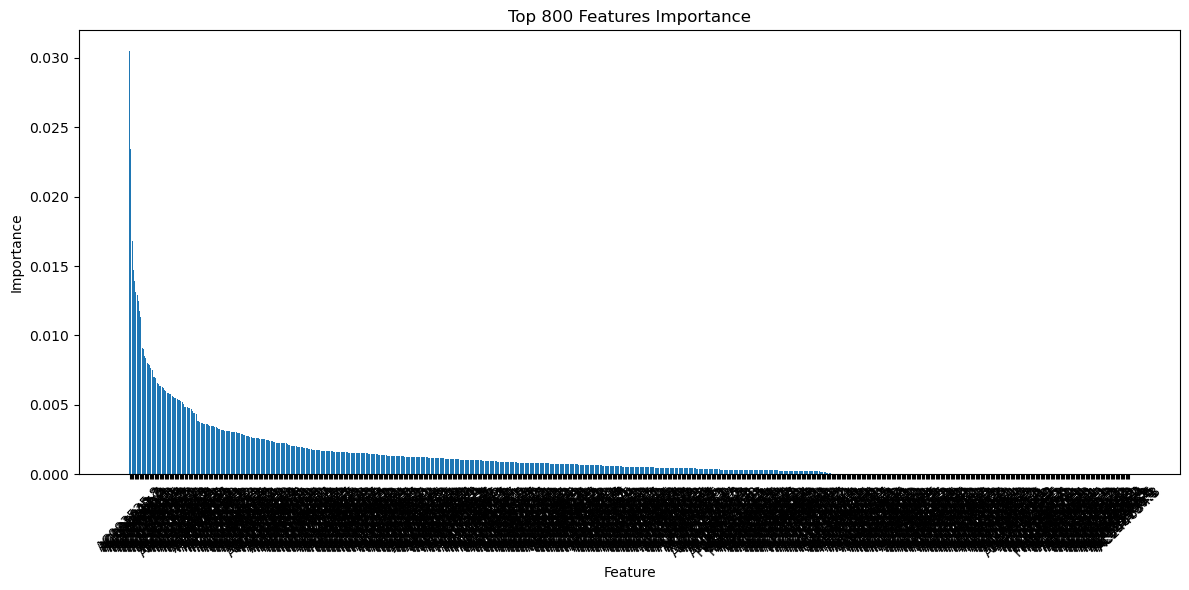

Last important feature:  561


In [22]:
df = pd.read_csv("../Datasets/Dataset12/data2.csv", index_col=0)

X = df.drop('Diagnosis', axis=1)
y = df['Diagnosis']

feature_names = X.columns

k_values = [800]

selected_features_dict = {}

for k in k_values:
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X, y)
    feature_importances = clf.feature_importances_
    selected_features = np.array(feature_names)[
        np.argsort(feature_importances)[::-1][:k]]

    selected_features_dict[k] = selected_features

    sorted_idx = np.argsort(feature_importances)[::-1]

    plt.figure(figsize=(12, 6))
    plt.title(f"Top {k} Features Importance")
    plt.bar(range(k), feature_importances[sorted_idx][:k], align="center")
    plt.xticks(range(k), np.array(feature_names)[sorted_idx][:k], rotation=45)
    plt.xlabel("Feature")
    plt.ylabel("Importance")
    plt.tight_layout()
    plt.show()

    zero_importance_index = np.where(feature_importances == 0)[0]
    print("Last important feature: ", len(
        X.columns)-len(zero_importance_index))

### Feature Selection

In [23]:
df = pd.read_csv("../Datasets/Dataset12/data2.csv", index_col=0)

X = df.drop('Diagnosis', axis=1)
y = df['Diagnosis']

feature_counts = list(range(1, 144))

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X, y)

feature_importances = clf.feature_importances_

selected_features = X.columns[np.argsort(feature_importances)[::-1]]

datasets = {}
for count in feature_counts:
    datasets[count] = X[selected_features[:count]].copy()
    datasets[count]['Diagnosis'] = y

for count, dataset in datasets.items():
    dataset.to_csv(
        f'../Datasets/Dataset12/Feature_Select/dataset_{count}.csv', index=True)

## Model Building

### Check CV Score for Different Models

In [24]:
feature_counts = list(range(1, 144))

models = {
    "SVM(linear)": SVC(kernel='linear'),
    "SVM(poly)": SVC(kernel='poly'),
    "Naive Bayes": GaussianNB(),
    "Logistic Regression": LogisticRegression(),
    "ANN": MLPClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(),
}

results = pd.DataFrame(
    columns=["Model Name", "Feature Count", "CV Score (Mean +/- Std)"])

for count in tqdm(feature_counts, desc="Processing feature counts", unit=" feature counts", colour='green'):
    file_path = f"../Datasets/Dataset12/Feature_Select/dataset_{count}.csv"
    df = pd.read_csv(file_path, index_col=0)

    X = df.drop('Diagnosis', axis=1)
    y = df['Diagnosis']

    for model_name, model in models.items():
        cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
        if model_name == "ANN":
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=ConvergenceWarning)
                scores = cross_val_score(model, X, y, cv=cv)
        elif model_name == "Logistic Regression": 
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=ConvergenceWarning)
                scores = cross_val_score(model, X, y, cv=cv)
        else:
            scores = cross_val_score(model, X, y, cv=cv)
        mean_score = np.mean(scores)
        std_score = np.std(scores)
        result = f"{mean_score:.4f} +/- {std_score:.4f}"
        new_data = pd.DataFrame({"Model Name": [model_name],
                                 "Feature Count": [count],
                                 "CV Score (Mean +/- Std)": [result]})
        results = pd.concat([results, new_data], ignore_index=True)
        # print(f"{model_name} with {count} features: {result}")

results.sort_values(by=["CV Score (Mean +/- Std)"],
                    ascending=False, inplace=True)
results.to_csv("../Datasets/Dataset12/Feature_Select/results.csv", index=False)

Processing feature counts: 100%|██████████| 143/143 [06:59<00:00,  2.94s/ feature counts]


In [25]:
df = pd.read_csv("../Datasets/Dataset12/Feature_Select/results.csv")
df.head(10)

Model Name  Feature Count CV Score (Mean +/- Std)
0  Random Forest              6       0.8138 +/- 0.0516
1  Random Forest            116       0.8138 +/- 0.0352
2    Naive Bayes             16       0.8069 +/- 0.0468
3    Naive Bayes             17       0.8069 +/- 0.0468
4  Random Forest             87       0.8069 +/- 0.0414
5  Random Forest             57       0.8069 +/- 0.0352
6  Random Forest             78       0.8069 +/- 0.0352
7  Random Forest             12       0.8069 +/- 0.0169
8    Naive Bayes             15       0.8000 +/- 0.0552
9    Naive Bayes             10       0.8000 +/- 0.0552

### Check Distributions

In [28]:
feature_count = 116

data = pd.read_csv(
    f'../Datasets/Dataset12/Feature_Select/dataset_{feature_count}.csv')

target_column = data.columns[feature_count + 1]

num_rows = math.ceil(feature_count / 4)
num_columns = 4

fig, axes = plt.subplots(num_rows, num_columns, figsize=(80, 140))

for i in range(min(feature_count, num_rows * num_columns)):
    row_index = i // num_columns
    col_index = i % num_columns

    sns.histplot(
        data=data, x=data.columns[i + 1], hue=target_column, kde=True, ax=axes[row_index, col_index])

    axes[row_index, col_index].set_title(
        f'Distribution of {data.columns[i + 1]}')

    axes[row_index, col_index].set_xlabel(data.columns[i + 1])

    axes[row_index, col_index].set_ylabel('Frequency')

plt.tight_layout()

plt.show()

### Check Accuracy

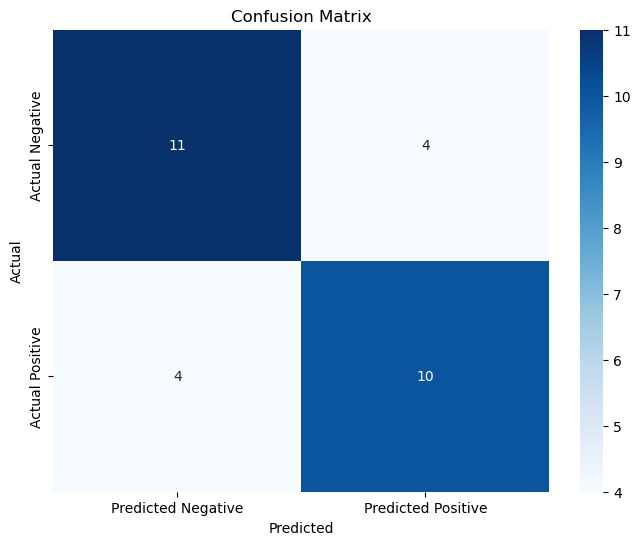

Accuracy: 0.72
Precision: 0.71
Recall (Sensitivity): 0.71
Specificity: 0.73
F1 Score: 0.71


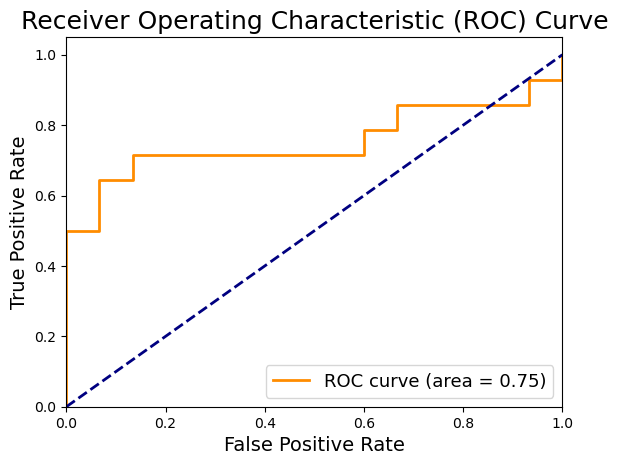

In [29]:
feature_count = 116

df = pd.read_csv(
    f'../Datasets/Dataset12/Feature_Select/dataset_{feature_count}.csv', index_col=0)

X = df.drop('Diagnosis', axis=1)
y = df['Diagnosis']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

clf = SVC(kernel='linear', probability=True)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

y_scores = clf.decision_function(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity = tn / (tn + fp)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall (Sensitivity): {recall:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"F1 Score: {f1:.2f}")

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=18)
plt.legend(loc='lower right', fontsize=13)
plt.show()